Il codice installa la libreria roboflow, rimuove una directory preesistente, si autentica con l'API di Roboflow utilizzando una chiave API, accede a uno specifico progetto e versione di un dataset annotato, e infine scarica il dataset in formato TFRecord. Questo processo è utile per ottenere dati annotati per l'addestramento di modelli di machine learning, come quelli utilizzati per la segmentazione delle immagini.


In [ ]:
!pip install roboflow
!rm -rf /content/yolov8-seg-2
from roboflow import Roboflow
rf = Roboflow(api_key="LdxQPIf7vJaSxI5OEPQr")
project = rf.workspace("santosh-ie6yy").project("yolov8-seg-4ezhu")
version = project.version(2)
dataset = version.download("tfrecord")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 640.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yolov8-seg-2 in tfrecord:: 100%|██████████| 11/11 [00:00<00:00, 21.03it/s]


Il codice importa librerie essenziali per il deep learning e la manipolazione dei dati, installa TensorFlow Addons per l'augmentation avanzata, e prepara l'ambiente per visualizzare e manipolare i dataset di immagini.

In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa  # Importa TensorFlow Addons per l'augmentation avanzata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00


Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons


In [ ]:
# Funzione per il parsing del TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64)
    }
    return tf.io.parse_single_example(example, feature_description)

# Caricamento del dataset TFRecord
def load_dataset(tfrecord_path):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
    num_images = sum(1 for _ in parsed_dataset)
    return parsed_dataset, num_images


In [ ]:
import tensorflow as tf
import numpy as np

def augment_image(image, boxes):
    image, boxes = random_flip_left_right(image, boxes)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Converti l'immagine in float per calcoli accurati delle bounding box
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Clip delle bounding boxes ai limiti dell'immagine
    boxes = clip_boxes(boxes, tf.shape(image))

    # Converti l'immagine nuovamente in uint8
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image, boxes

def random_flip_left_right(image, boxes):
    if tf.random.uniform(()) > 0.5:  # 50% di probabilità di flip
        image = tf.image.flip_left_right(image)

        # Flip delle coordinate x delle bounding boxes
        xmin, xmax = boxes[:, 0], boxes[:, 1]
        flipped_xmin = 1.0 - xmax
        flipped_xmax = 1.0 - xmin
        flipped_boxes = tf.stack([flipped_xmin, flipped_xmax, boxes[:, 2], boxes[:, 3]], axis=-1)

        return image, flipped_boxes

    return image, boxes


def clip_boxes(boxes, image_shape):
    # Clip delle coordinate x e y
    clipped_boxes = tf.stack([
        tf.clip_by_value(boxes[:, 0], 0.0, 1.0),
        tf.clip_by_value(boxes[:, 1], 0.0, 1.0),
        tf.clip_by_value(boxes[:, 2], 0.0, 1.0),
        tf.clip_by_value(boxes[:, 3], 0.0, 1.0)
    ], axis=-1)

    return clipped_boxes

def create_tf_example(image, filename, height, width, boxes, labels):
    encoded_image = tf.io.encode_jpeg(image).numpy()
    xmins, xmaxs, ymins, ymaxs = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    feature_dict = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=labels))
    }

    tf_example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return tf_example

def save_tfrecord(dataset, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    for image, filename, height, width, boxes, labels in dataset:
        tf_example = create_tf_example(image, filename, height, width, boxes, labels)
        writer.write(tf_example.SerializeToString())
    writer.close()

def augment_and_save_datasets(input_tfrecord_paths, output_tfrecord_path, max_augmented_images):
    writer = tf.io.TFRecordWriter(output_tfrecord_path)
    count = 0

    def _parse_function(example_proto):
        feature_description = {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        }
        parsed_example = tf.io.parse_single_example(example_proto, feature_description)
        return parsed_example

    all_images_data = []

    for input_tfrecord_path in input_tfrecord_paths:
        raw_dataset = tf.data.TFRecordDataset(input_tfrecord_path)
        parsed_dataset = raw_dataset.map(_parse_function)

        for data in parsed_dataset:
            image = tf.image.decode_jpeg(data['image/encoded'])
            height, width = data['image/height'].numpy(), data['image/width'].numpy()
            filename = data['image/filename'].numpy().decode('utf8')
            xmin = tf.sparse.to_dense(data['image/object/bbox/xmin']).numpy()
            xmax = tf.sparse.to_dense(data['image/object/bbox/xmax']).numpy()
            ymin = tf.sparse.to_dense(data['image/object/bbox/ymin']).numpy()
            ymax = tf.sparse.to_dense(data['image/object/bbox/ymax']).numpy()
            boxes = np.stack([xmin, xmax, ymin, ymax], axis=1)
            labels = tf.sparse.to_dense(data['image/object/class/label']).numpy()

            all_images_data.append((image, filename, height, width, boxes, labels))

            # Salvataggio dell'immagine originale
            tf_example = create_tf_example(image, filename, height, width, boxes, labels)
            writer.write(tf_example.SerializeToString())

    # Applicazione dell'augmentation in modo circolare
    while count < max_augmented_images:
        for image, filename, height, width, boxes, labels in all_images_data:
            if count >= max_augmented_images:
                break
            aug_image, aug_boxes = augment_image(image, boxes)
            tf_example_aug = create_tf_example(aug_image, filename, height, width, aug_boxes, labels)
            writer.write(tf_example_aug.SerializeToString())
            count += 1

    writer.close()

def main():
    train_input_tfrecord_path = '/content/yolov8-seg-2/train/road-pothole-XFXB.tfrecord'
    valid_input_tfrecord_path = '/content/yolov8-seg-2/valid/road-pothole-XFXB.tfrecord'
    test_input_tfrecord_path = '/content/yolov8-seg-2/test/road-pothole-XFXB.tfrecord'

    augmented_output_tfrecord_path = '/content/augmented1000.tfrecord'

    max_augmented_images = 345

    input_tfrecord_paths = [
        train_input_tfrecord_path,
        valid_input_tfrecord_path,
        test_input_tfrecord_path
    ]

    augment_and_save_datasets(input_tfrecord_paths, augmented_output_tfrecord_path, max_augmented_images)

if __name__ == "__main__":
    main()


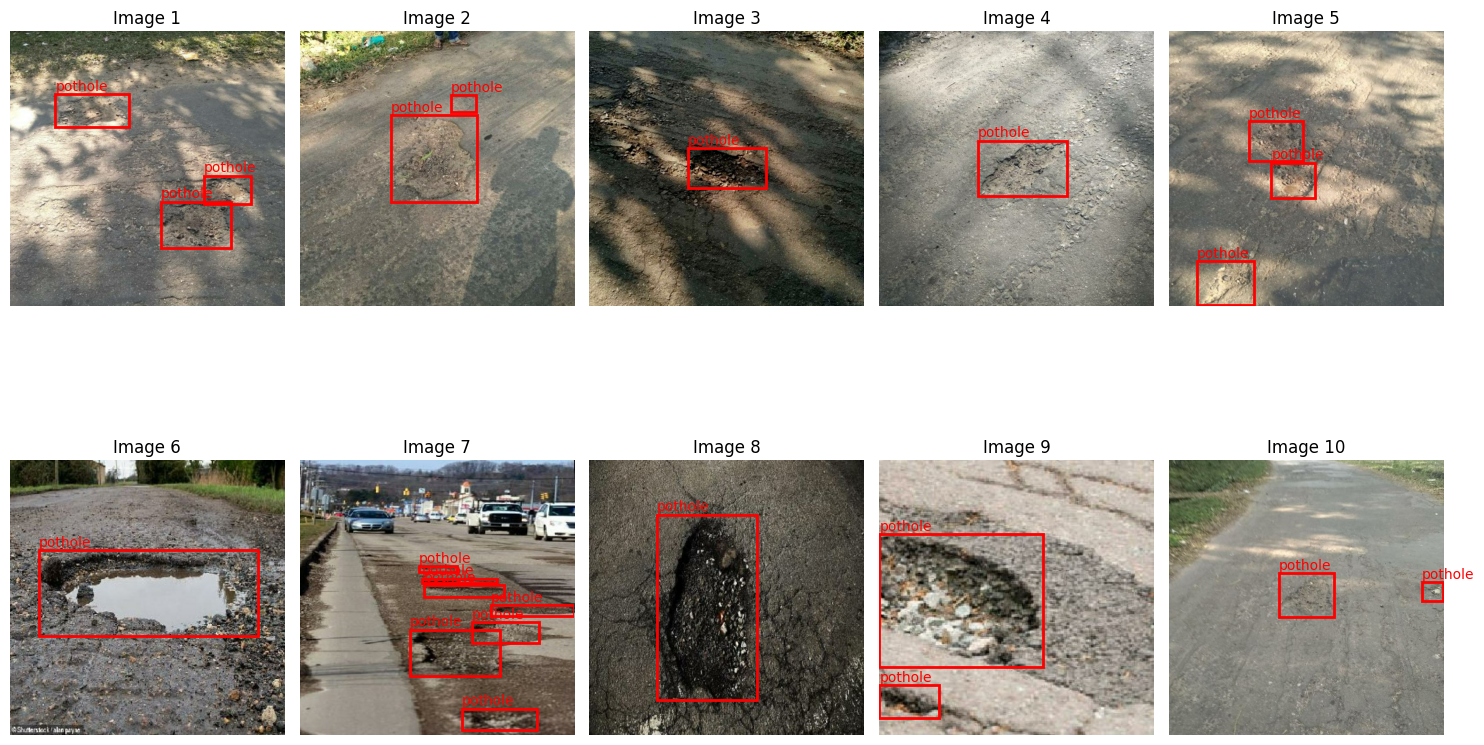

Numero totale di immagini nel dataset: 1000


In [ ]:
import matplotlib.pyplot as plt
# Funzione per visualizzare le immagini con bounding box
def visualize_images_with_boxes(dataset, num_images=10):
    plt.figure(figsize=(15, 10))

    for i, data in enumerate(dataset.take(num_images)):
        image = tf.image.decode_jpeg(data['image/encoded'])
        image_height = data['image/height'].numpy()
        image_width = data['image/width'].numpy()
        xmin = tf.sparse.to_dense(data['image/object/bbox/xmin']).numpy()
        xmax = tf.sparse.to_dense(data['image/object/bbox/xmax']).numpy()
        ymin = tf.sparse.to_dense(data['image/object/bbox/ymin']).numpy()
        ymax = tf.sparse.to_dense(data['image/object/bbox/ymax']).numpy()

        boxes = np.stack([ymin, xmin, ymax - ymin, xmax - xmin], axis=-1)
        labels = tf.sparse.to_dense(data['image/object/class/label']).numpy()

        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Image {i + 1}')

        for box, label in zip(boxes, labels):
            y, x, h, w = box
            bbox = patches.Rectangle((x * image_width, y * image_height),
                                     w * image_width, h * image_height,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(bbox)
            ax.text(x * image_width, y * image_height - 10, f'pothole',
                    fontsize=10, color='r')

    plt.tight_layout()
    plt.show()

def main():
    tfrecord_path = '/content/augmented1000.tfrecord'
    dataset, num_images = load_dataset(tfrecord_path)

    # Prendiamo 10 immagini a caso dal dataset
    random.seed(42)
    sampled_dataset = dataset.shuffle(buffer_size=1000).take(10)

    # Visualizziamo le immagini con i bounding box
    visualize_images_with_boxes(sampled_dataset)

    # Stampiamo il numero totale di immagini nel dataset
    print(f"Numero totale di immagini nel dataset: {num_images}")

if __name__ == "__main__":
    main()



In [ ]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
!rm -rf /content/yolov8_dataset

def parse_function(example_proto):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def extract_and_save_images(tfrecord_path, output_dir):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    parsed_dataset = raw_dataset.map(parse_function)

    count = 0  # Contatore per il numero di esempi processati

    for data in parsed_dataset:
        count += 1  # Incrementa il contatore ad ogni iterazione
        image = tf.image.decode_jpeg(data['image/encoded']).numpy()
        height, width = data['image/height'].numpy(), data['image/width'].numpy()

        # Genera un nome univoco per l'immagine
        filename = f'image_{count}.jpg'

        xmin = tf.sparse.to_dense(data['image/object/bbox/xmin']).numpy()
        xmax = tf.sparse.to_dense(data['image/object/bbox/xmax']).numpy()
        ymin = tf.sparse.to_dense(data['image/object/bbox/ymin']).numpy()
        ymax = tf.sparse.to_dense(data['image/object/bbox/ymax']).numpy()
        boxes = np.stack([xmin, xmax, ymin, ymax], axis=1)
        labels = tf.sparse.to_dense(data['image/object/class/label']).numpy()

        # Save image
        image_path = os.path.join(output_dir, 'images', filename)
        Image.fromarray(image).save(image_path)

        # Save annotation in YOLO format
        annotation_filename = f'image_{count}.txt'
        annotation_path = os.path.join(output_dir, 'labels', annotation_filename)
        with open(annotation_path, 'w') as f:
            lines = []
            for box, label in zip(boxes, labels):
                label -= 1  # Decrementa di 1 per convertire da indice 1-based a indice 0-based
                x_center = (box[0] + box[1]) / 2
                y_center = (box[2] + box[3]) / 2
                box_width = box[1] - box[0]
                box_height = box[3] - box[2]
                line = f'{label} {x_center} {y_center} {box_width} {box_height}'
                lines.append(line)

            for i, line in enumerate(lines):
                if i != len(lines) - 1:
                    f.write(line + '\n')
                else:
                    f.write(line)

    print(f"Numero totale di esempi processati: {count}")

def main():
    augmented_tfrecord_path = '/content/augmented1000.tfrecord'
    output_dir = '/content/yolov8_dataset'

    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    extract_and_save_images(augmented_tfrecord_path, output_dir)

if __name__ == "__main__":
    main()


Numero totale di esempi processati: 1000


Crea il zip da esportare contenente il dataset in formato yolo8

In [ ]:
!rm -rf /content/yolov8_dataset.zip
!zip -r /content/yolov8_dataset.zip /content/yolov8_dataset

  adding: content/yolov8_dataset/ (stored 0%)
  adding: content/yolov8_dataset/images/ (stored 0%)
  adding: content/yolov8_dataset/images/image_819.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_101.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_460.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_151.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_840.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_421.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_816.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_729.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_756.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_387.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_620.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_963.jpg (deflated 0%)
  adding: content/yolov8_dataset/images/image_311.jpg (deflated 0%)
  adding: content